In [1]:
import sys
sys.path.append('../')
sys.dont_write_bytecode = True
import os
import numpy as np
import scipy.ndimage
from matplotlib.pyplot import *
%matplotlib inline
import numba
sys.path.append('/Users/Michael_Saha/Repositories/')
sys.path.append('./../../../')
from fire_sim import *

### Variable Descriptions
```fires``` - The coordinates of all fires that have burnt. A 2-tuple of numpy arrays ($y,x$).

```active``` - A 'cursor' that shows the range of pixels that are currently burning. This will be a contiguous range, as the active pixels will be visited in linear order. Simulation invariant: ```active[1]``` is the total number of fires that have started in the whole simulation. The $(y,x)$ coordinates all fires after the simulation has run is: ```(fires[0][:active[1]], fires[1][:active[1]])```

```B``` - The 2d map of biomes. Each biome is associated with a distribution of land covers. For example, a chapparal biome would have more shrub land cover and a defensible space biome would have more inflammable land cover.

```L``` - The 2d map of land cover types {inflammable, grass, shrub}. Each land cover type has burn properties that are drawn from a land-cover specific random distribution. Land cover type 0 is inflammable; it will not burn, accumulate energy, or release energy.

```E``` - The 2d map of accumulated energies. This is the matrix where, after a nearby pixel has burned and transmitted its energy to a neighborhood, the energy is stored/tallied. This builds up over the whole course of the simulation (never decays temporally).

```A``` - The 2d map of energies required ignite a cell. When ```E[i,j]``` exceeds ```A[i,j]```, then a fire ignites in the cell. These values are drawn from a gamma distribution with landcover-specific parameters.

```R``` - 2d map of energy released when a cell is burned. The values in ```R``` are drawn from a gamma distribution with landcover-specific parameters. After ignition, the energy in ```R[i,j]``` is distributed among neighbors such that the total energy distributed is equal to ```R[i,j]```. The energy distributed to a givel pixel $p_{k,l}$ is equal to  
$$\frac{R_{i,j}}{d^{2}}f$$
* $d$ is the Euclidean distance from pixel $(i,j)$ to pixel $(k,l)$  
* $(i,j) \ne (k,l)$  
* $d<r$. We put an upper bound on the radius/neighborhood to which energy is delivered to speed up computation.  
* $f$ is an adjustment factor: $f=\frac{1}{\Sigma{d^{2}}}$.  

```F``` - The 2d map of all fires that have burnt. The pixel value at ```F[i,j]``` is a integer value indicating the iteration on which ```E[i,j]``` first exceeded the ```A[i,j]```. If ```F[i,j]``` is ```0```, then the pixel has not been burnt. 


In [2]:
GRASS = 1
SHRUB = 2

def valid_parameters(A_params, R_params):
    """Evaluate the parameters w.r.t. the biophysical contraints.
    
    Ex. 1: The mean energy released by shrubs should exceed the mean
    energy released by grasses.
    
    Ex. 2: The mean energy required to ignite shrubs should exceed
    the same amount of energy required to ignite grasses.
    """
    return (A_params[SHRUB][0] > A_parames[GRASS][0] and 
            A_params[SHRUB][1] > A_parames[GRASS][1] and
            R_params[SHRUB][0] > R_params[GRASS][0] and
            R_params[SHRUB][1] > R_params[GRASS][1])

In [3]:
# Needed for simulation
B = np.zeros((500,500))
B[250:] = 1

landcover_distr = (0.25, 0.45, 0.3), (0.34, 0.36, 0.3)  # For each Biome

A_params = (np.nan, np.nan), (3.00, 0.30), (2.00, 0.30)
R_params = (np.nan, np.nan), (2.00, 1.65), (1.00, 1.65)
A_distr = [parameterize(np.random.gamma,*p) for p in A_params]
R_distr = [parameterize(np.random.gamma,*p) for p in R_params]

sim = Simulation(B, landcover_distr, A_distr, R_distr)
#ignitions = tuple(a.flatten() for a in np.meshgrid(range(249,260),range(249,260)))
#sim.ignite_fires(ignitions)

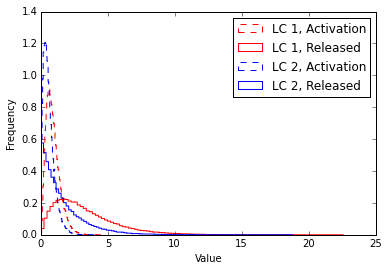

In [4]:
h = hist(sim.A[sim.L==1],100, histtype='step', normed='True', color='r', ls='dashed', label='LC 1, Activation')
h = hist(sim.R[sim.L==1],100, histtype='step', normed='True', color='r', ls='solid', label='LC 1, Released')
h = hist(sim.A[sim.L==2],100, histtype='step', normed='True', color='b', ls='dashed', label='LC 2, Activation')
h = hist(sim.R[sim.L==2],100, histtype='step', normed='True', color='b', ls='solid', label='LC 2, Released')
xlabel('Value')
ylabel('Frequency')
legend()

(0, 500)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


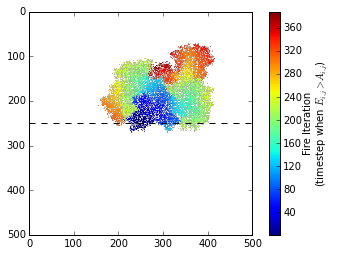

In [27]:
sim = Simulation(B, landcover_distr, A_distr, R_distr)
ignitions = tuple(a.flatten() for a in np.meshgrid(range(240,260),range(240,260)))
sim.run(ignitions)

fig = figure()
sim.showF()
colorbar(label='Fire Iteration\n(timestep when $E_{i,j} > A_{i,j}$)')
plot([0,500],[250,250],'k--');ylim(500,0);xlim(0,500)